======================================================
### **Student Information:**
* Name= Fatemeh
* Last Name= Azizabadi Farahani
* ID= 99205315

======================================================

# **Gaussian Mixture Models Implementation**



This is a full implementation of Gaussian Mixture Models in Python.

Let's first import the libraries we are going to be using throughout the exercise:

## **Import Packages**

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
from PIL import Image
from scipy.stats import multivariate_normal
import math
import time

## **Reading Image**

In [ ]:
image = cv2.imread('/content/ponyo.jpeg')

h, w, d = image.shape
X=np.reshape(image,(h * w, 3))

# **GMM CLASS**

In [2]:
class GMM:
    
    def __init__(self,k=3, max_iter=20, early_stopping=False, tol=5, verbose=False, plot_every=None, random_state=None):
        
        self.K = k # define k 
        self.max_iter = max_iter
        self.early_stopping = early_stopping
        self.tol = tol # early stopping threshold
        self.verbose = verbose # how NLL while training
        self.plot_every = False if plot_every == None else plot_every # if not define iterative plot
        self.prev_nll = 0 # NLL comparator
        
        if random_state: np.random.seed(random_state) # define if random state was init
    
    def fit(self, X):
        
        time_start = time.time() # init time start
        
        m,n  = X.shape # get m n
        
        # init responsibility (Likelihood coresponding for each class)
        self.r = np.full(shape=(m, self.K), fill_value=1/self.K)
        
        # init pi (identity pi for each k)
        self.pi = np.full((self.K, ), fill_value=1/self.K)
        
        # init mean (random mean LL of classes by random from samples)
        init_points = np.random.randint(low=0, high=m, size=self.K)
        self.mean = np.array([X[idx,:] for idx in init_points ]).T
        
        # init covariance (covariance for each class)
        self.cov = np.array([np.cov(X.T) for _ in range (self.K)])
        
        # looping
        iter = 0
        while iter < self.max_iter:
            
            # ================================= E step================================================
            
            # ----------------------  Find Likelihood ------------------------
            for i in range(m): # for every samples
                for k in range(self.K): # in each class of sample i
                    xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[:, k], cov=self.cov[k]) # calc gaussian prob. of xi in class i 
                    self.r[i, k] = self.pi[k] * xi_pdf # multiply gs. prob. by pi of class i -> save at r at sample i, class k
                self.r[i] /= np.sum(self.r[i]) # normalize likelihood

            # ------------------------ find neg likelihood --------------------- (metric of GMM)(similar to cost value)
            NLL = 0 # init NLL at 0.0
            for i in range(m): # for each sample
                for k in range(self.K): # in each class k
                    NLL += math.log(self.pi[k]) # log of pi of class k at sample i
                    NLL += multivariate_normal.logpdf(X[i], mean=self.mean[:, k], cov=self.cov[k]) # accumulate gs prob 

            # ------------- every 5 iteration plot once---------------------
            
            if self.plot_every and iter % self.plot_every ==0:
                preds = np.argmax(self.r, axis=1)
                plt.figure()
                plt.scatter(X[:, 0], X[:, 1], c=preds)
                plt.title(f"Iteration: {iter}")
                plt.show()
                
            if self.verbose: # if verbose set True -> show cost at iter i+1
                print(f'iter {iter+1}, different NLL: {math.fabs(NLL - self.prev_nll)}')

            # ------------------------------ Check if early stop -----------------------
            # if early stopping was set and abs(difference of NLL) < tolerance -> stop
            if(self.early_stopping and math.fabs(NLL-self.prev_nll) < self.tol): # fabs following Task 1
                
                if self.verbose:
                    print('Early Stopped with tol: ', self.tol)
                #print("Final NLL: ", NLL)
                    print("final difference: ", math.fabs(NLL - self.prev_nll)) # ignoring negative sign
                break
            
            # if not continue iteration with set current NLL
            self.prev_nll = NLL

            #=========================================M Step==============================================
            
            # Find NK first for later use
            self.NK = np.sum(self.r, axis=0)
            assert self.NK.shape == (self.K, )

            #PI
            self.pi = self.NK / m
            assert self.pi.shape == (self.K, )

            #mean
            self.mean =  ( X.T @ self.r ) / self.NK
            assert self.mean.shape == (n, self.K)

            # ------------------------------------- update sigma ---------------------------------------------
            
            # update sigma of gm
            for k in range(self.K): # for each class k
                for i in range(m): # in each sample i
                    X_mean = (X[i]-self.mean[:, k]).reshape(-1, 1) # calc means
                    self.cov[k] += self.r[i, k] * (X_mean @ X_mean.T) # calc covatiance
                self.cov[k] /= self.NK[k] # after each k -> cumulative divide by NK
            assert self.cov.shape == (self.K, n, n)
            
            iter += 1 # go next iteration
        
        self.fit_time = time.time() - time_start # when fitting ended -> save fitting time
        
        if self.verbose: print(f'fitting time: {self.fit_time} seconds') # show fitting time

    def predict(self, X):
        
        m,n = X.shape # get m n of xtest
        
        preds = np.zeros(shape=(m, self.K)) # init result coresponding each k
        
        for i in range(m): # for each x test i
            for k in range(self.K): # in each class k
                
                xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[:, k], cov=self.cov[k]) # calc gs prob
                preds[i, k] = self.pi[k] * xi_pdf # miltoply it by pi of class k
                
            preds[i] /= np.sum(preds[i]) # normalize likelihood
            
        return np.argmax(preds, axis=1) # return argmax
    
    def predict_proba(self, X):
        
        m,n = X.shape # get m n of xtest
        
        preds = np.zeros(shape=(m, self.K)) # init result coresponding each k
        
        for i in range(m): # for each x test i
            for k in range(self.K): # in each class k
                
                xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[:, k], cov=self.cov[k]) # calc gs prob
                preds[i, k] = self.pi[k] * xi_pdf # miltoply it by pi of class k
                
            preds[i] /= np.sum(preds[i]) # normalize likelihood
            
        return preds # return raw before argmax



## **Reading Image**

In [3]:
image = cv2.imread('/content/ponyo.jpeg')

h, w, d = image.shape
X=np.reshape(image,(h * w, 3))

## **Training**

In [4]:
gmm = GMM(k=6, max_iter=10)
gmm.fit(X)

In [5]:
gmm_labels = gmm.predict(X)
gmm_labels_= np.array(gmm_labels, dtype=np.uint8)
gmm_labels_.shape

(50625,)

In [10]:
likelihood_=gmm.predict_proba(X)

In [11]:
likelihood_.shape

(50625, 6)

In [6]:
k=6
sum=np.zeros((k,3))
num=np.zeros((k,3))
mean=np.zeros((k,3))
for i in range(0,gmm_labels_.shape[0]):
  cluster=gmm_labels_[i]
  for j in range(0,3):
    sum[cluster][j]=sum[cluster][j]+X[i][j]
    num[cluster][j]=num[cluster][j]+1

for i in range(0,k):
  for j in range(0,3):
    mean[i][j]=sum[i][j]/num[i][j]

mean

array([[187.12325831, 168.98874598, 127.41211147],
       [177.7315825 , 169.24283094, 124.63029835],
       [226.15229598, 190.14668102, 104.39112376],
       [145.43300654,  78.90141612, 161.93627451],
       [116.63940272,  74.30406359,  68.55337642],
       [ 85.81761006, 104.28531688, 231.79571843]])

In [7]:
## recunstruction of Image with k cluster of colors
X__=X
for i in range(0,gmm_labels_.shape[0]):
  mean_color=gmm_labels_[i]
  for j in range(0,2):
    X__[i][j]=mean[mean_color][j]


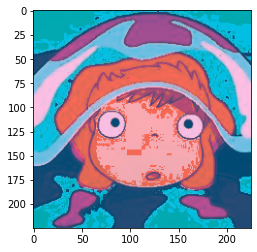

In [8]:
X_reconstructed = np.array(X__, dtype=np.uint8)
reduced_image = np.reshape(X_reconstructed, (h, w, d))
plt.imshow(cv2.cvtColor(reduced_image, cv2.COLOR_BGR2RGB))
plt.show()

## **Ploting contours**

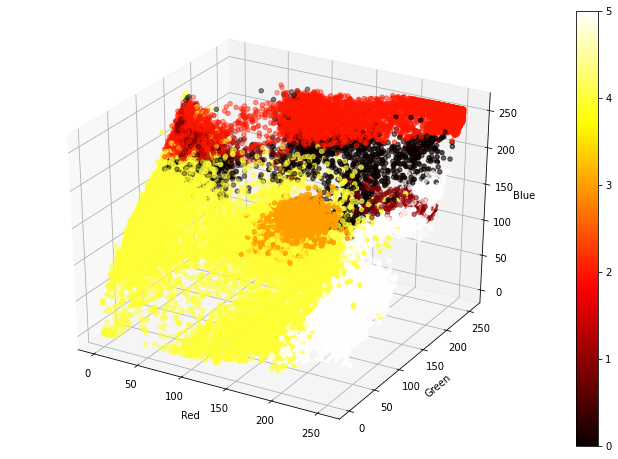

In [18]:
image_path = "/content/ponyo.jpeg"


fig = pyplot.figure(figsize=(12, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d") # 3D plot with scalar values in each axis

im = Image.open(image_path)
r, g, b = list(im.getdata(0)), list(im.getdata(1)), list(im.getdata(2))

axis.scatter(r, g, b,c=gmm_labels_,cmap=plt.hot())
fig.colorbar(img)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
pyplot.show()

# **Checking with Gaussian Mixture from  sklearn.mixture**

**This Part is just for Esurance**

In [26]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=6).fit(X) 
gmm_labels = gmm.predict(X)
Color=gmm.means_
gmm_labels_= np.array(gmm_labels, dtype=np.uint8)


In [27]:
## recunstruction of Image with k cluster of colors
X__=X
for i in range(0,gmm_labels_.shape[0]):
  mean_color=gmm_labels_[i]
  for j in range(0,2):
    X__[i][j]=Color[mean_color][j]


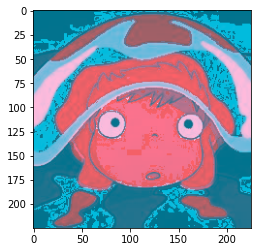

In [28]:
X_reconstructed = np.array(X__, dtype=np.uint8)
reduced_image = np.reshape(X_reconstructed, (h, w, d))
plt.imshow(cv2.cvtColor(reduced_image, cv2.COLOR_BGR2RGB))
plt.show()